In [2]:
import os
from skimage.feature import hog
from skimage import exposure
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf

import cv2

import seaborn as sns
import matplotlib.pyplot as plt




In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
base_path = '/content/drive/.shortcut-targets-by-id/1W01KwNde9fWkWs9206tNtZsdc3BVs97m/anomaly/mvtec_anomaly_detection/'


In [5]:
# Specify the list of classes (folders)
classes = ["zipper", "wood", "transistor", "toothbrush", "tile", "screw", "pill", "metal_nut", "leather", "hazelnut", "grid", "carpet", "capsule", "cable", "bottle"]


In [6]:
def load_and_preprocess_image(image_path, target_size=(180, 180)):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Normalize the pixel values to the [0, 1] range
    image = image.astype("float32") / 255.0
    return image

In [7]:
# Initialize lists to store images and labels
images_train = []
labels_train = []

images_test = []
labels_test = []


In [8]:
# Load and preprocess the images for the training dataset (only "good" class)
for class_name in classes:
    train_folder = os.path.join(base_path, class_name, "train", "good")

    for filename in os.listdir(train_folder):
        image_path = os.path.join(train_folder, filename)
        image = load_and_preprocess_image(image_path, target_size=(180, 180))  # Load and preprocess your image
        images_train.append(image)
        labels_train.append(0)


In [9]:
print('Dimension of objects in the list images_train: ', images_train[0].shape)
print('Number of samples in the list images_train: ', len(images_train))



Dimension of objects in the list images_train:  (180, 180, 3)
Number of samples in the list images_train:  3629


In [10]:
# Load and preprocess the images for the testing dataset (both "good" and "defected" classes)
for class_name in classes:
    test_folder = os.path.join(base_path, class_name, "test")

    for folder_name in os.listdir(test_folder):
        defect_folder = os.path.join(test_folder, folder_name)

        for filename in os.listdir(defect_folder):
            image_path = os.path.join(defect_folder, filename)
            image = load_and_preprocess_image(image_path, target_size=(180, 180))
            images_test.append(image)
            labels_test.append(0 if folder_name == "good" else 1)


In [11]:
print('Dimension of objects in the list images_test: ', images_test[0].shape)
print('Number of samples in the list images_test: ', len(images_test))


Dimension of objects in the list images_test:  (180, 180, 3)
Number of samples in the list images_test:  1725


In [12]:
# Convert the data to numpy arrays
X_train = np.array(images_train)
X_test = np.array(images_test)

# Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [13]:
X_train[0].shape, X_test[0].shape

((180, 180, 3), (180, 180, 3))

In [23]:
# Stacked Autoencoder for Color Images
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(180 * 180 * 3),
    tf.keras.layers.Reshape([180, 180, 3])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mse", optimizer="nadam")

In [24]:
# Train the stacked autoencoder with X_train as both input and output
history = stacked_ae.fit(X_train, X_train, epochs=20)

Epoch 1/20
114/114 [==============================] - 3s 11ms/step - loss: 1.1016e-06
Epoch 2/20
114/114 [==============================] - 1s 10ms/step - loss: 9.9621e-07
Epoch 3/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9661e-07
Epoch 4/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9786e-07
Epoch 5/20
114/114 [==============================] - 1s 10ms/step - loss: 9.9725e-07
Epoch 6/20
114/114 [==============================] - 1s 10ms/step - loss: 9.9862e-07
Epoch 7/20
114/114 [==============================] - 1s 10ms/step - loss: 9.9815e-07
Epoch 8/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9756e-07
Epoch 9/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9737e-07
Epoch 10/20
114/114 [==============================] - 1s 10ms/step - loss: 9.9679e-07
Epoch 11/20
114/114 [==============================] - 1s 10ms/step - loss: 9.9780e-07
Epoch 12/20
114/114 [==============================]

In [25]:
# Use the trained autoencoder to reconstruct images from X_test
reconstructed_images = stacked_ae.predict(X_test)

# Calculate reconstruction errors (MSE)
reconstruction_errors = np.mean(np.square(X_test - reconstructed_images), axis=(1, 2, 3))


54/54 [==============================] - 0s 6ms/step


In [26]:
reconstruction_errors

array([1.4877376e-06, 1.5397719e-06, 1.5145959e-06, ..., 2.0754180e-06,
       2.0963319e-06, 2.1035214e-06], dtype=float32)

In [27]:
# Define the desired percentile (e.g., 95th percentile)
desired_percentile = 50


# Calculate the threshold as the specified percentile
threshold_precentile = np.percentile(reconstruction_errors, desired_percentile)

# Print the calculated threshold
print(f"Threshold at {desired_percentile}th percentile: {threshold_precentile:.2e}")

Threshold at 50th percentile: 9.55e-07


In [28]:
# Set an anomaly detection threshold (adjust as needed)
threshold = threshold_precentile

# Identify defected images based on the threshold
defected_indices = np.where(reconstruction_errors > threshold)[0]
defected_images = X_test[defected_indices]


In [29]:
len(defected_images)

862

In [30]:
# Create predicted_labels array
predicted_labels = np.zeros(len(X_test))
predicted_labels[defected_indices] = 1

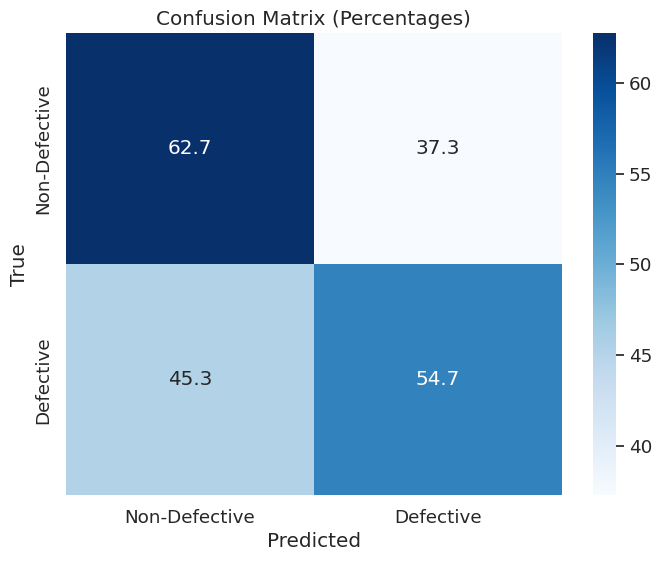

Confusion Matrix:
[[293 174]
 [570 688]]
True Positives (TP): 688
False Positives (FP): 174
True Negatives (TN): 293
False Negatives (FN): 570
Precision: 0.798
Recall: 0.547
F1-Score: 0.649


In [31]:
# Create the confusion matrix
confusion_mat = confusion_matrix(labels_test, predicted_labels)

# Calculate TP, FP, TN, FN values
TP = confusion_mat[1, 1]
FP = confusion_mat[0, 1]
TN = confusion_mat[0, 0]
FN = confusion_mat[1, 0]

# Calculate precision, recall, and F1-score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a confusion matrix plot (percentages)
cm_percentage = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Non-Defective", "Defective"],
            yticklabels=["Non-Defective", "Defective"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(confusion_mat)
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")
